## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
    *  Mix Visual Transformer
* use only 3 slices
* slide inference

In [1]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss, fbeta_score
import pickle
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW
from torch.optim.lr_scheduler import _LRScheduler, CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

import datetime
import wandb

import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/timm-054/pytorch-image-models-054')
sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-0.3.2')

import segmentation_models_pytorch as smp

## config

In [2]:
class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '/kaggle/input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1
    TTA = True
    # ============== model cfg =============
    model_name = 'Unet'
    backbone = 'mit_b5'
#     backbone = 'se_resnext101_32x4d'

    in_chans = 3 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 8

    batch_size = 64 # 32
    valid_batch_size = batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 15
    warmup_epochs = 1  # Adjust the value according to your needs
    warmup_factor = 10
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 2

    objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== augmentation =============
    train_aug_list = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3), 
                        mask_fill_value=0, p=0.5),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


In [3]:
IS_DEBUG = False
mode = 'train' if IS_DEBUG else 'test'
TH = 0.43

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## helper

In [5]:
# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    # pixels = (pixels >= thr).astype(int)
    
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

## dataset

In [6]:
def read_image(fragment_id, mode):
    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - (CFG.in_chans - 1) // 2
    end = mid + (CFG.in_chans + 1) // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"{mode}/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)
    
    return images

In [7]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.xyxys)
        return len(self.images)

    def __getitem__(self, idx):
        # x1, y1, x2, y2 = self.xyxys[idx]
        image = self.images[idx]
        data = self.transform(image=image)
        image = data['image']
        return image

In [8]:
def make_test_dataset(fragment_id):
    test_images = read_image(fragment_id, mode='test')  # Replace 'test' with the correct mode if needed
    
    x1_list = list(range(0, test_images.shape[1]-CFG.tile_size+1, CFG.stride))
    y1_list = list(range(0, test_images.shape[0]-CFG.tile_size+1, CFG.stride))
    
    test_images_list = []
    xyxys = []
    for y1 in y1_list:
        for x1 in x1_list:
            y2 = y1 + CFG.tile_size
            x2 = x1 + CFG.tile_size
            
            test_images_list.append(test_images[y1:y2, x1:x2])
            xyxys.append((x1, y1, x2, y2))
    xyxys = np.stack(xyxys)
            
    test_dataset = CustomDataset(test_images_list, CFG, transform=get_transforms(data='valid', cfg=CFG))
    
    test_loader = DataLoader(test_dataset,
                          batch_size=CFG.batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    return test_loader, xyxys

## model

In [9]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        output = output.squeeze(-1)
        return output

def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)
    return model


In [10]:
class EnsembleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.ModuleList()
        for fold in [1, 2, 3]:
            _model = build_model(CFG, weight=None)
#             _model.to(device)
            model_path = f'/kaggle/input/vesuvius-models-unet-mit-b5/Unet_mit_b5_fold{fold}_best.pth'
            state = torch.load(model_path)['model']
            _model.load_state_dict(state)
            _model.eval()
            self.model.append(_model)

    def forward(self, x):
        output = []
        for m in self.model:
            output.append(m(x))
        output=torch.stack(output,dim=0).mean(0)
        return output

In [11]:
def TTA(x:torch.Tensor,model:nn.Module):
    #x.shape=(batch,c,h,w)
    if CFG.TTA:
        shape=x.shape
        x=[x,*[torch.rot90(x,k=i,dims=(-2,-1)) for i in range(1,4)]]
        x=torch.cat(x,dim=0)
        x=model(x)
        x=torch.sigmoid(x)
        x=x.reshape(4,shape[0],*shape[2:])
        x=[torch.rot90(x[i],k=-i,dims=(-2,-1)) for i in range(4)]
        x=torch.stack(x,dim=0)
        return x.mean(0)
    else :
        x=model(x)
        x=torch.sigmoid(x)
        return x

In [12]:
if mode == 'test':
    fragment_ids = sorted(os.listdir(CFG.comp_dataset_path + mode))
else:
    fragment_ids = [3]
model = EnsembleModel()
model = nn.DataParallel(model, device_ids=[0, 1])
model = model.cuda()

model_name Unet
backbone mit_b5
model_name Unet
backbone mit_b5
model_name Unet
backbone mit_b5


## main

  0%|          | 0/3 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/342 [00:00<?, ?it/s]

mask_count_min: 1.0


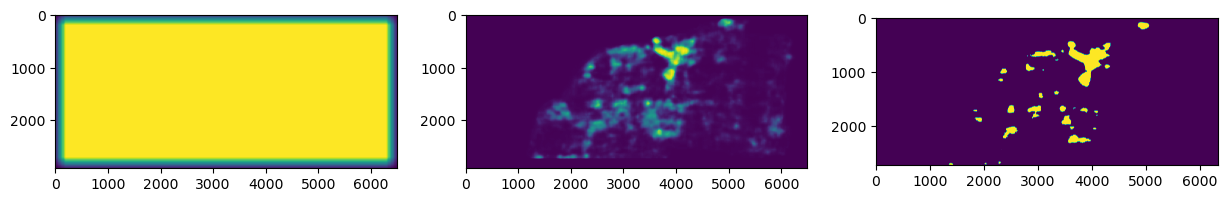

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/679 [00:00<?, ?it/s]

mask_count_min: 1.0


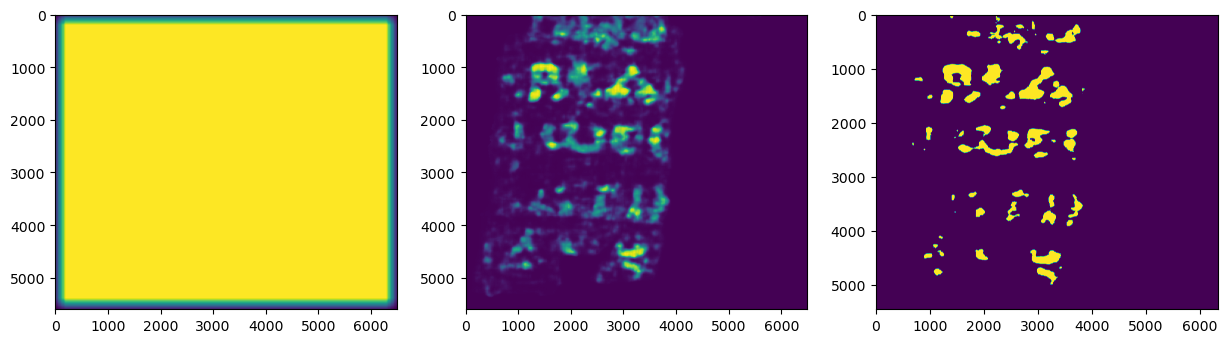

In [13]:
results = []
for fragment_id in fragment_ids:
    
    test_loader, xyxys = make_test_dataset(fragment_id)
    
    binary_mask = cv2.imread(CFG.comp_dataset_path + f"{mode}/{fragment_id}/mask.png", 0)
    binary_mask = (binary_mask / 255).astype(int)
    
    ori_h = binary_mask.shape[0]
    ori_w = binary_mask.shape[1]
    # mask = mask / 255

    pad0 = (CFG.tile_size - binary_mask.shape[0] % CFG.tile_size)
    pad1 = (CFG.tile_size - binary_mask.shape[1] % CFG.tile_size)

    binary_mask = np.pad(binary_mask, [(0, pad0), (0, pad1)], constant_values=0)
    
    mask_pred = np.zeros(binary_mask.shape)
    mask_count = np.zeros(binary_mask.shape)

    for step, (images) in tqdm(enumerate(test_loader), total=len(test_loader)):
        images = images.cuda()
        batch_size = images.size(0)

        with torch.no_grad():
            y_preds = TTA(images,model).cpu().numpy()

        start_idx = step*CFG.batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].reshape(mask_pred[y1:y2, x1:x2].shape)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))
    
    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 8))
    axes[0].imshow(mask_count)
    axes[1].imshow(mask_pred.copy())
    
    
    
    mask_pred = mask_pred[:ori_h, :ori_w]
    binary_mask = binary_mask[:ori_h, :ori_w]
    
    mask_pred = (mask_pred >= TH).astype(int)
    mask_pred *= binary_mask
    axes[2].imshow(mask_pred)
    plt.show()
    
    inklabels_rle = rle(mask_pred)
    
    results.append((fragment_id, inklabels_rle))
    

    del mask_pred, mask_count
    del test_loader
    
    gc.collect()
    torch.cuda.empty_cache()

## submission

In [14]:
sub = pd.DataFrame(results, columns=['Id', 'Predicted'])

In [15]:
sub

,Id,Predicted
0,a,599923 9 606241 37 612567 48 618892 58 625218 ...
1,b,1372 63 7684 91 14010 98 20338 102 26667 105 3...


In [16]:
sample_sub = pd.read_csv(CFG.comp_dataset_path + 'sample_submission.csv')
sample_sub = pd.merge(sample_sub[['Id']], sub, on='Id', how='left')

In [17]:
sample_sub

,Id,Predicted
0,a,599923 9 606241 37 612567 48 618892 58 625218 ...
1,b,1372 63 7684 91 14010 98 20338 102 26667 105 3...


In [18]:
sample_sub.to_csv("submission.csv", index=False)